# Transfer learning with Tensorflow: Feature Extration

In [31]:
# check gpu
!nvidia-smi

Thu Jan 11 17:02:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0              32W /  70W |   8323MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Download and becoming one with the data


In [32]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2024-01-11 17:02:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.207, 173.194.215.207, 173.194.216.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   128MB/s    in 1.3s    

2024-01-11 17:02:35 (128 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [33]:
import zipfile

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [34]:
# how many images in each folder
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent/"):
  print(f'there are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

there are 2 directories and 0 images in 10_food_classes_10_percent/
there are 10 directories and 0 images in 10_food_classes_10_percent/test
there are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
there are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
there are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
there are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
there are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
there are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
there are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
there are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
there are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
there are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
there are 10 director

## Create data loader (preprocessing the data)

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data_10_percent = train_datagen.flow_from_directory(directory=train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical',
                                                          shuffle=True)

test_data_10_percent = test_datagen.flow_from_directory(directory=test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical')

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up callbacks

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training with the EarlyStopping callback

In [36]:
# Create TensorBoard callback
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving TensorBoard log files to: {log_dir}')
  return tensorboard_callback

In [37]:
create_tensorboard_callback("hi", "world")

Saving TensorBoard log files to: hi/world/20240111-170238


## Creating models using TensorFlow Hub

In [38]:
# compare the following two models
resnet_url = "https://www.kaggle.com/models/tensorflow/resnet-50/frameworks/TensorFlow2/variations/feature-vector/versions/1"
efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-feature-vector/versions/1"

In [39]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


In [40]:
# Create_model function to create a model from a url

def create_model(model_url, num_classes=10):
  """
  Takes a tensorflow hub url and creates a keras Sequential modle with it.

  Args:
     model_url (str): A Tensorflow hub feature extraction url
     num_classes (int): Number of output neurons in the output layer

     returns:
        An uncompiled Keras Sequential model with model_url as feature extractor layers
  """

  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,))

  #Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation='softmax', name="output_layer")
  ])

  return model



### Creating and test ResNet tensoflow hub feature extraction model

In [41]:
# Create a ResNet model

resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [42]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23561152  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23581642 (89.96 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23561152 (89.88 MB)
_________________________________________________________________


In [43]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])



In [44]:
history_resnet = resnet_model.fit(train_data_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data_10_percent,
                              validation_steps=len(test_data_10_percent),
                              callbacks=[create_tensorboard_callback("tensorflow_hub","resenet50")])

Saving TensorBoard log files to: tensorflow_hub/resenet50/20240111-170255
Epoch 1/5
24/24 [==============================] - 22s 579ms/step - loss: 1.8825 - accuracy: 0.4053 - val_loss: 1.1053 - val_accuracy: 0.6324
Epoch 2/5
24/24 [==============================] - 14s 582ms/step - loss: 0.8496 - accuracy: 0.7480 - val_loss: 0.7122 - val_accuracy: 0.7932
Epoch 3/5
24/24 [==============================] - 12s 531ms/step - loss: 0.5722 - accuracy: 0.8493 - val_loss: 0.6297 - val_accuracy: 0.8060
Epoch 4/5
24/24 [==============================] - 13s 549ms/step - loss: 0.4440 - accuracy: 0.8840 - val_loss: 0.5890 - val_accuracy: 0.8160
Epoch 5/5
24/24 [==============================] - 12s 531ms/step - loss: 0.3512 - accuracy: 0.9213 - val_loss: 0.5546 - val_accuracy: 0.8224


In [45]:
# Create a function to plot our loss curves
import matplotlib.pyplot as plt

def plot_loss_curve(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epoch = range(len(history.history['loss']))

  plt.plot(epoch, loss, label='training_loss')
  plt.plot(epoch, val_loss, label='validation_loss')
  plt.title("loss curves")
  plt.legend()

  plt.figure()
  plt.plot(epoch, acc, label='training_accuracy')
  plt.plot(epoch, val_acc, label='validation_accuracy')
  plt.title('accuracy curves')
  plt.legend()


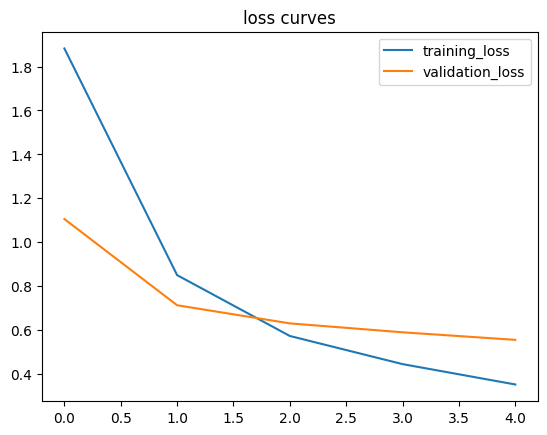

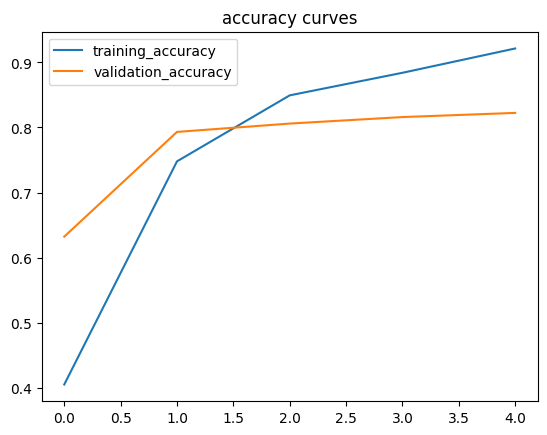

In [46]:
plot_loss_curve(history_resnet)

 ### Creating and testing EfficientNetB0 Tensorflow hub Feature Extraction